In [124]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [125]:


df = pd.read_csv('/content/wfp_food_prices_uga.csv')
display(df.head())

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+flag,#item+price+type,#currency,#value,#value+usd
1,2006-01-15,Lira,Lira Municipality,Lira,2.235,32.909722,cereals and tubers,Maize,KG,actual,Wholesale,UGX,247.76,0.1362
2,2006-02-15,Busia,Samia-bugwe,Busia,0.467,34.09,cereals and tubers,Maize,KG,actual,Wholesale,UGX,296.59,0.1639
3,2006-02-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Maize,KG,actual,Wholesale,UGX,347.23,0.1918
4,2006-02-15,Lira,Lira Municipality,Lira,2.235,32.909722,cereals and tubers,Maize,KG,actual,Wholesale,UGX,253.19,0.1399


In [126]:
df = df.copy()
df = df.iloc[1:].copy()
df['date'] = pd.to_datetime(df['date'])
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['price'] = df['price'].fillna(df['price'].mean())

In [127]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_no_outliers = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

print(f"Original DataFrame shape: {df.shape}")
print(f"DataFrame shape after outlier removal: {df_no_outliers.shape}")

df = df_no_outliers.copy()

Original DataFrame shape: (14418, 14)
DataFrame shape after outlier removal: (12934, 14)


In [128]:
df = df[df['category'] != 'non-food']
df.columns

Index(['date', 'admin1', 'admin2', 'market', 'latitude', 'longitude',
       'category', 'commodity', 'unit', 'priceflag', 'pricetype', 'currency',
       'price', 'usdprice'],
      dtype='object')

In [129]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

features = ['admin1', 'market','month','year','commodity','pricetype','latitude','longitude','unit','category']
target = 'price'

X = df[features].copy()
y = df[target].copy()

In [130]:
categorical_features = [col for col in ['admin1', 'market','unit','category','pricetype','commodity'] if col in X.columns]

for feature in categorical_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])

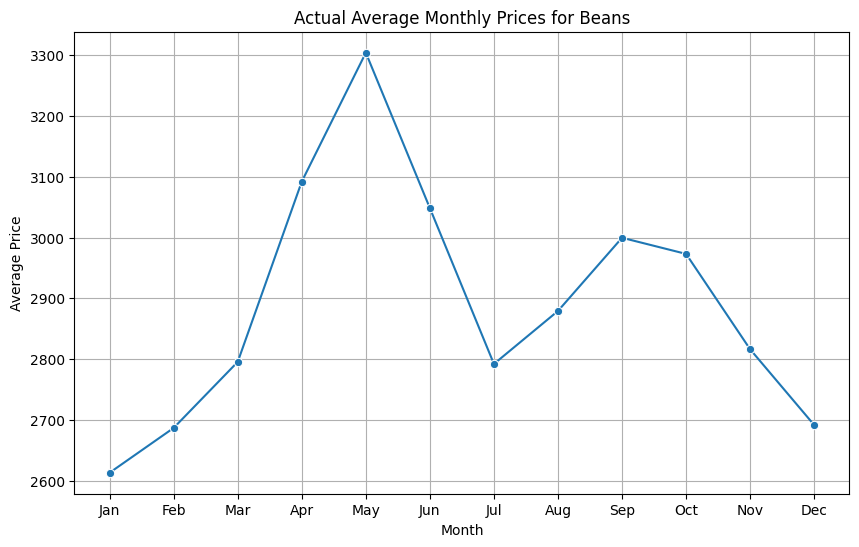

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

beans_df = df[df['commodity'] == 'Beans'].copy()

monthly_avg_beans_price = beans_df.groupby('month')['price'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='price', data=monthly_avg_beans_price, marker='o')
plt.title('Actual Average Monthly Prices for Beans')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [132]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [133]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.values.reshape(-1, 1)).flatten()

display(X_train.head())
display(y_train[:5])

,admin1,market,month,year,commodity,pricetype,latitude,longitude,unit,category
10070,34,41,10,2022,2,0,0.69433,34.179499,0,0
2875,5,5,9,2016,0,0,2.766667,32.305556,0,5
7547,8,34,2,2022,1,0,-0.941207194,30.76188819,0,0
8048,7,7,4,2022,6,0,0.609167,33.468611,0,0
1902,23,21,4,2014,0,1,2.235,32.909722,0,5


array([ 0.09500305,  0.42922465, -1.34951404, -0.48765931,  0.03380731])

In [134]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred_rf = model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)


y_pred_rf_train = model.predict(X_train)
mse_rftrain = mean_squared_error(y_train, y_pred_rf_train)
rmse_rftrain = np.sqrt(mse_rftrain)
r2_rftrain = r2_score(y_train, y_pred_rf_train)
mae_rftrain = mean_absolute_error(y_train, y_pred_rf_train)


print(f'Random Forest - Mean Squared Error: {mse_rf}')
print(f'Random Forest - Root Mean Squared Error: {rmse_rf}')
print(f'Random Forest - R-squared: {r2_rf}')
print(f'Random Forest - Mean Absolute Error: {mae_rf}')

print(f'Random Forest (Train) - Mean Squared Error: {mse_rftrain}')
print(f'Random Forest (Train) - Root Mean Squared Error: {rmse_rftrain}')
print(f'Random Forest (Train) - R-squared: {r2_rftrain}')
print(f'Random Forest (Train) - Mean Absolute Error: {mae_rftrain}')

Random Forest - Mean Squared Error: 0.05820767195717432
Random Forest - Root Mean Squared Error: 0.2412626617551384
Random Forest - R-squared: 0.9474435711522281
Random Forest - Mean Absolute Error: 0.15619719566414167
Random Forest (Train) - Mean Squared Error: 0.009281960687600784
Random Forest (Train) - Root Mean Squared Error: 0.09634293273302813
Random Forest (Train) - R-squared: 0.9907180393123992
Random Forest (Train) - Mean Absolute Error: 0.06120832311341694


In [135]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

param_dist_rf = {
    'n_estimators': np.arange(50, 300, 50),
    'max_features': ['sqrt', 'log2', 0.6, 0.8, 1.0],
    'max_depth': np.arange(5, 30, 5),
    'min_samples_split': np.arange(2, 10, 1),
     'bootstrap': [True],
    'min_samples_leaf': np.arange(1, 5, 1)

}


rf_model = RandomForestRegressor(random_state=42)

random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_rf,
    n_iter=50,
    cv=5,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)


random_search_rf.fit(X_train, y_train)

best_params_rf = random_search_rf.best_params_
print("Best parameters found by RandomizedSearchCV for Random Forest Regressor:")
print(best_params_rf)


tuned_rf_model = random_search_rf.best_estimator_


y_pred_tuned_rf = tuned_rf_model.predict(X_test)

mse_tuned_rf = mean_squared_error(y_test, y_pred_tuned_rf)
rmse_tuned_rf = np.sqrt(mse_tuned_rf)
r2_tuned_rf = r2_score(y_test, y_pred_tuned_rf)
mae_tuned_rf = mean_absolute_error(y_test, y_pred_tuned_rf)
print(f'\nTuned Random Forest - Mean Squared Error: {mse_tuned_rf}')
print(f'Tuned Random Forest  - Root Mean Squared Error: {rmse_tuned_rf}')
print(f'Tuned Random Forest  - R-squared: {r2_tuned_rf}')
print(f'Tuned Random Forest  - Mean Absolute Error: {mae_tuned_rf}')







Best parameters found by RandomizedSearchCV for Random Forest Regressor:
{'n_estimators': np.int64(150), 'min_samples_split': np.int64(3), 'min_samples_leaf': np.int64(1), 'max_features': 1.0, 'max_depth': np.int64(20), 'bootstrap': True}

Tuned Random Forest - Mean Squared Error: 0.05812939723031355
Tuned Random Forest  - Root Mean Squared Error: 0.24110038828320776
Tuned Random Forest  - R-squared: 0.9475142463738013
Tuned Random Forest  - Mean Absolute Error: 0.15810671551081906


,Feature,Importance
9,category,0.334095
4,commodity,0.232531
3,year,0.207498
8,unit,0.065153
2,month,0.047747
7,longitude,0.038952
6,latitude,0.027355
1,market,0.022687
0,admin1,0.017903
5,pricetype,0.006079


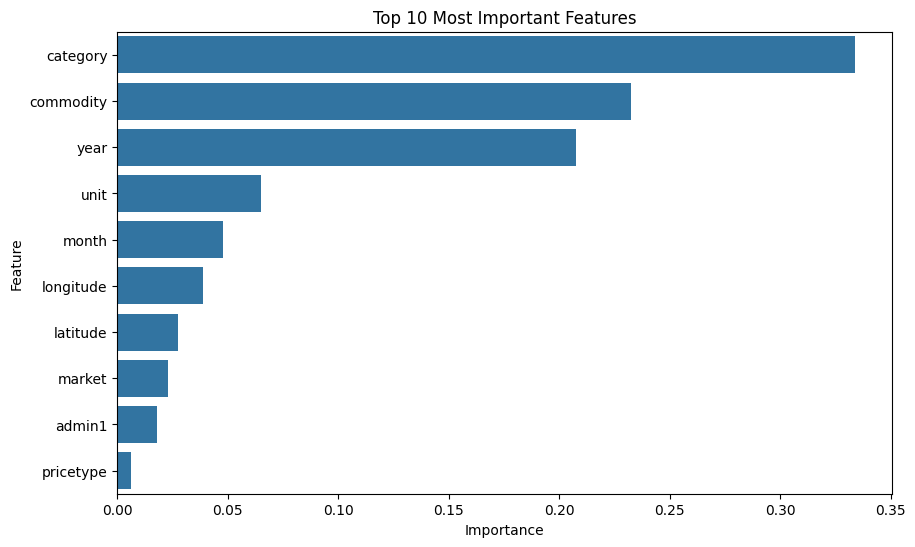

In [136]:
feature_importances = model.feature_importances_

features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

display(importance_df.head(10))
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Most Important Features')
plt.show()

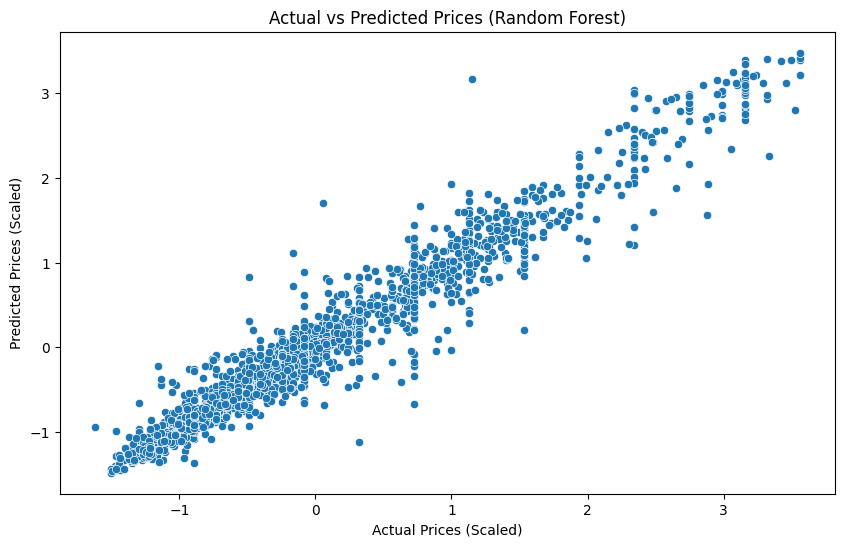

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.xlabel("Actual Prices (Scaled)")
plt.ylabel("Predicted Prices (Scaled)")
plt.title("Actual vs Predicted Prices (Random Forest)")
plt.show()

In [138]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [139]:

nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
      Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

nn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,777 (46.00 KB)

 Non-trainable params: 0 (0.00 B)

In [140]:
from sklearn.preprocessing import StandardScaler

scaler_X_nn = StandardScaler()
X_train_scaled_nn = scaler_X_nn.fit_transform(X_train)
X_test_scaled_nn = scaler_X_nn.transform(X_test)

print("X_train_scaled_nn shape:", X_train_scaled_nn.shape)
print("X_test_scaled_nn shape:", X_test_scaled_nn.shape)

X_train_scaled_nn shape: (8525, 10)
X_test_scaled_nn shape: (2132, 10)


In [141]:

nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled_nn.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_scaled_nn = nn_model.fit(
    X_train_scaled_nn.astype(np.float32),
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.6250 - mae: 0.5960 - mse: 0.6250 - val_loss: 0.3107 - val_mae: 0.4354 - val_mse: 0.3107
Epoch 2/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2973 - mae: 0.4136 - mse: 0.2973 - val_loss: 0.2567 - val_mae: 0.3749 - val_mse: 0.2567
Epoch 3/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2325 - mae: 0.3595 - mse: 0.2325 - val_loss: 0.2477 - val_mae: 0.3877 - val_mse: 0.2477
Epoch 4/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2135 - mae: 0.3419 - mse: 0.2135 - val_loss: 0.2104 - val_mae: 0.3421 - val_mse: 0.2104
Epoch 5/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2065 - mae: 0.3342 - mse: 0.2065 - val_loss: 0.1983 - val_mae: 0.3345 - val_mse: 0.1983
Epoch 6/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1851 - mae: 0.3173 - mse: 0.1851 - val_loss: 0.1906 - val_mae: 0.3254 - val_mse: 0.1906
Epoch 7/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1770 - mae: 0.3069 - mse: 0.1770 - val_loss

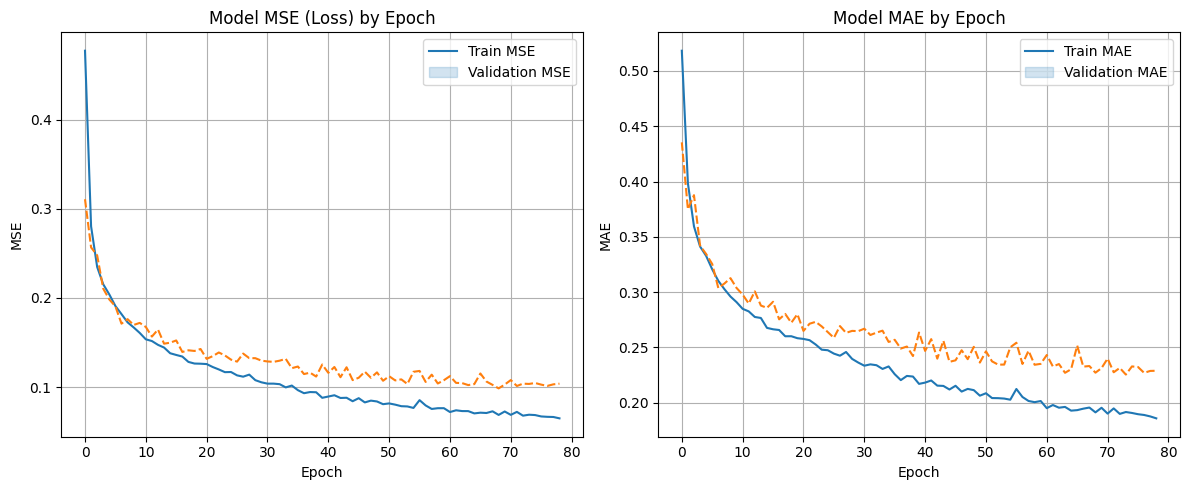

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

history_df = pd.DataFrame(history_scaled_nn.history)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['mse', 'val_mse']])
plt.title('Model MSE (Loss) by Epoch')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train MSE', 'Validation MSE'], loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['mae', 'val_mae']])
plt.title('Model MAE by Epoch')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train MAE', 'Validation MAE'], loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [143]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

y_pred_scaled_nn = nn_model.predict(X_test_scaled_nn.astype(np.float32))

mse_scaled_nn = mean_squared_error(y_test, y_pred_scaled_nn)
rmse_scaled_nn = np.sqrt(mse_scaled_nn)
r2_scaled_nn = r2_score(y_test, y_pred_scaled_nn)
mae_scaled_nn = mean_absolute_error(y_test, y_pred_scaled_nn)

print(f'Neural Network (Scaled Features) (Test) - Mean Squared Error: {mse_scaled_nn}')
print(f'Neural Network (Scaled Features) (Test) - Root Mean Squared Error: {rmse_scaled_nn}')
print(f'Neural Network (Scaled Features) (Test) - R-squared: {r2_scaled_nn}')
print(f'Neural Network (Scaled Features) (Test) - Mean Absolute Error: {mae_scaled_nn}')


y_pred_scaled_nn_train = nn_model.predict(X_train_scaled_nn.astype(np.float32))
mse_scaled_nn_train = mean_squared_error(y_train, y_pred_scaled_nn_train)
rmse_scaled_nn_train = np.sqrt(mse_scaled_nn_train)
r2_scaled_nn_train = r2_score(y_train, y_pred_scaled_nn_train)
mae_scaled_nn_train = mean_absolute_error(y_train, y_pred_scaled_nn_train)

print(f'Neural Network (Scaled Features) (Train) - Mean Squared Error: {mse_scaled_nn_train}')
print(f'Neural Network (Scaled Features) (Train) - Root Mean Squared Error: {rmse_scaled_nn_train}')
print(f'Neural Network (Scaled Features) (Train) - R-squared: {r2_scaled_nn_train}')
print(f'Neural Network (Scaled Features) (Train) - Mean Absolute Error: {mae_scaled_nn_train}')

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network (Scaled Features) (Test) - Mean Squared Error: 0.09967687443548566
Neural Network (Scaled Features) (Test) - Root Mean Squared Error: 0.3157164462543655
Neural Network (Scaled Features) (Test) - R-squared: 0.9100005139719178
Neural Network (Scaled Features) (Test) - Mean Absolute Error: 0.2253082398469193
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neural Network (Scaled Features) (Train) - Mean Squared Error: 0.06798648924955303
Neural Network (Scaled Features) (Train) - Root Mean Squared Error: 0.2607421892397796
Neural Network (Scaled Features) (Train) - R-squared: 0.932013510750447
Neural Network (Scaled Features) (Train) - Mean Absolute Error: 0.18756053028645342


In [144]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)


X_train_scaled shape: (8525, 10)
X_test_scaled shape: (2132, 10)


In [145]:
from sklearn.neighbors import KNeighborsRegressor

knn_tuned_scaled = KNeighborsRegressor(n_neighbors=4, weights='distance', metric='manhattan')

knn_tuned_scaled.fit(X_train_scaled, y_train)

y_pred_knn_scaled = knn_tuned_scaled.predict(X_test_scaled)

print("KNN model trained and predictions made on scaled data.")

KNN model trained and predictions made on scaled data.


In [146]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

param_dist_knn = {
    'n_neighbors': np.arange(1, 30, 1),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsRegressor()

random_search_knn = RandomizedSearchCV(estimator=knn, param_distributions=param_dist_knn, n_iter=20, cv=5, random_state=42, n_jobs=-1)

random_search_knn.fit(X_train_scaled, y_train)

best_params_knn = random_search_knn.best_params_
best_estimator_knn = random_search_knn.best_estimator_

print("Best parameters found by RandomizedSearchCV for KNN:")
print(best_params_knn)

y_pred_tuned_knn_test = best_estimator_knn.predict(X_test_scaled)

mse_tuned_knn_test = mean_squared_error(y_test, y_pred_tuned_knn_test)
rmse_tuned_knn_test = np.sqrt(mse_tuned_knn_test)
r2_tuned_knn_test = r2_score(y_test, y_pred_tuned_knn_test)
mae_tuned_knn_test = mean_absolute_error(y_test, y_pred_tuned_knn_test)

print(f'\nTuned KNN (Test) - Mean Squared Error: {mse_tuned_knn_test}')
print(f'Tuned KNN (Test) - Root Mean Squared Error: {rmse_tuned_knn_test}')
print(f'Tuned KNN (Test) - R-squared: {r2_tuned_knn_test}')
print(f'Tuned KNN (Test) - Mean Absolute Error: {mae_tuned_knn_test}')


y_pred_tuned_knn_train = best_estimator_knn.predict(X_train_scaled)

mse_tuned_knn_train = mean_squared_error(y_train, y_pred_tuned_knn_train)
rmse_tuned_knn_train = np.sqrt(mse_tuned_knn_train)
r2_tuned_knn_train = r2_score(y_train, y_pred_tuned_knn_train)
mae_tuned_knn_train = mean_absolute_error(y_train, y_pred_tuned_knn_train)

print(f'\nTuned KNN (Train) - Mean Squared Error: {mse_tuned_knn_train}')
print(f'Tuned KNN (Train) - Root Mean Squared Error: {rmse_tuned_knn_train}')
print(f'Tuned KNN (Train) - R-squared: {r2_tuned_knn_train}')
print(f'Tuned KNN (Train) - Mean Absolute Error: {mae_tuned_knn_train}')

Best parameters found by RandomizedSearchCV for KNN:
{'weights': 'distance', 'n_neighbors': np.int64(4), 'metric': 'manhattan'}

Tuned KNN (Test) - Mean Squared Error: 0.17766327274529933
Tuned KNN (Test) - Root Mean Squared Error: 0.4215012132192496
Tuned KNN (Test) - R-squared: 0.8395856278229015
Tuned KNN (Test) - Mean Absolute Error: 0.2993062850863819

Tuned KNN (Train) - Mean Squared Error: 0.0
Tuned KNN (Train) - Root Mean Squared Error: 0.0
Tuned KNN (Train) - R-squared: 1.0
Tuned KNN (Train) - Mean Absolute Error: 0.0


In [147]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
print("Decision Tree Regressor model trained successfully.")

Decision Tree Regressor model trained successfully.


In [148]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

y_pred_dt = dt_model.predict(X_test)

mse_dt_test = mean_squared_error(y_test, y_pred_dt)
rmse_dt_test = np.sqrt(mse_dt_test)
r2_dt_test = r2_score(y_test, y_pred_dt)
mae_dt_test = mean_absolute_error(y_test, y_pred_dt)

print(f'Initial Decision Tree (Test) - Mean Squared Error: {mse_dt_test}')
print(f'Initial Decision Tree (Test) - Root Mean Squared Error: {rmse_dt_test}')
print(f'Initial Decision Tree (Test) - R-squared: {r2_dt_test}')
print(f'Initial Decision Tree (Test) - Mean Absolute Error: {mae_dt_test}')

y_pred_dt_train = dt_model.predict(X_train)
mse_dt_train = mean_squared_error(y_train, y_pred_dt_train)
rmse_dt_train = np.sqrt(mse_dt_train)
r2_dt_train = r2_score(y_train, y_pred_dt_train)
mae_dt_train = mean_absolute_error(y_train, y_pred_dt_train)

print(f'\nInitial Decision Tree (Train) - Mean Squared Error: {mse_dt_train}')
print(f'Initial Decision Tree (Train) - Root Mean Squared Error: {rmse_dt_train}')
print(f'Initial Decision Tree (Train) - R-squared: {r2_dt_train}')
print(f'Initial Decision Tree (Train) - Mean Absolute Error: {mae_dt_train}')

Initial Decision Tree (Test) - Mean Squared Error: 0.11010978183457425
Initial Decision Tree (Test) - Root Mean Squared Error: 0.33182794010537187
Initial Decision Tree (Test) - R-squared: 0.9005805125020255
Initial Decision Tree (Test) - Mean Absolute Error: 0.1927044820785711

Initial Decision Tree (Train) - Mean Squared Error: 5.1813728181256605e-34
Initial Decision Tree (Train) - Root Mean Squared Error: 2.2762629061963954e-17
Initial Decision Tree (Train) - R-squared: 1.0
Initial Decision Tree (Train) - Mean Absolute Error: 2.3262590941192797e-18


In [149]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
import numpy as np

param_dist_dt = {
    'max_depth': np.arange(5, 50, 5),
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 20, 2),
    'max_features': ['sqrt', 'log2', None]
}

dt = DecisionTreeRegressor(random_state=42)

random_search_dt = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist_dt,
    n_iter=50,
    cv=5,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

random_search_dt.fit(X_train, y_train)

best_params_dt = random_search_dt.best_params_
best_estimator_dt = random_search_dt.best_estimator_

print("Best parameters found by RandomizedSearchCV for Decision Tree Regressor:")
print(best_params_dt)

Best parameters found by RandomizedSearchCV for Decision Tree Regressor:
{'min_samples_split': np.int64(14), 'min_samples_leaf': np.int64(1), 'max_features': None, 'max_depth': np.int64(25)}


In [150]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

y_pred_tuned_dt = best_estimator_dt.predict(X_test)

mse_tuned_dt = mean_squared_error(y_test, y_pred_tuned_dt)
rmse_tuned_dt = np.sqrt(mse_tuned_dt)
r2_tuned_dt = r2_score(y_test, y_pred_tuned_dt)
mae_tuned_dt = mean_absolute_error(y_test, y_pred_tuned_dt)

print(f'Tuned Decision Tree - Mean Squared Error: {mse_tuned_dt}')
print(f'Tuned Decision Tree - Root Mean Squared Error: {rmse_tuned_dt}')
print(f'Tuned Decision Tree - R-squared: {r2_tuned_dt}')
print(f'Tuned Decision Tree - Mean Absolute Error: {mae_tuned_dt}')


print("\nComparison with Initial Decision Tree model:")
print(f'Initial Decision Tree - Mean Squared Error: {mse_dt_test}')
print(f'Initial Decision Tree - Root Mean Squared Error: {rmse_dt_test}')
print(f'Initial Decision Tree - R-squared: {r2_dt_test}')
print(f'Initial Decision Tree - Mean Absolute Error: {mae_dt_test}')



Tuned Decision Tree - Mean Squared Error: 0.094491048592261
Tuned Decision Tree - Root Mean Squared Error: 0.3073939631682135
Tuned Decision Tree - R-squared: 0.9146828604355748
Tuned Decision Tree - Mean Absolute Error: 0.20318222418423504

Comparison with Initial Decision Tree model:
Initial Decision Tree - Mean Squared Error: 0.11010978183457425
Initial Decision Tree - Root Mean Squared Error: 0.33182794010537187
Initial Decision Tree - R-squared: 0.9005805125020255
Initial Decision Tree - Mean Absolute Error: 0.1927044820785711


In [151]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr_test = lr_model.predict(X_test_scaled)

mse_lr_test = mean_squared_error(y_test, y_pred_lr_test)
rmse_lr_test = np.sqrt(mse_lr_test)
r2_lr_test = r2_score(y_test, y_pred_lr_test)
mae_lr_test = mean_absolute_error(y_test, y_pred_lr_test)


print(f'Linear Regression (Test) - Mean Squared Error: {mse_lr_test}')
print(f'Linear Regression (Test) - Root Mean Squared Error: {rmse_lr_test}')
print(f'Linear Regression (Test) - R-squared: {r2_lr_test}')
print(f'Linear Regression (Test) - Mean Absolute Error: {mae_lr_test}')


y_pred_lr_train = lr_model.predict(X_train_scaled)
mse_lr_train = mean_squared_error(y_train, y_pred_lr_train)
rmse_lr_train = np.sqrt(mse_lr_train)
r2_lr_train = r2_score(y_train, y_pred_lr_train)
mae_lr_train = mean_absolute_error(y_train, y_pred_lr_train)

print(f'\nLinear Regression (Train) - Mean Squared Error: {mse_lr_train}')
print(f'Linear Regression (Train) - Root Mean Squared Error: {rmse_lr_train}')
print(f'Linear Regression (Train) - R-squared: {r2_lr_train}')
print(f'Linear Regression (Train) - Mean Absolute Error: {mae_lr_train}')

Linear Regression (Test) - Mean Squared Error: 0.6913166320333806
Linear Regression (Test) - Root Mean Squared Error: 0.8314545279408734
Linear Regression (Test) - R-squared: 0.3758016398684456
Linear Regression (Test) - Mean Absolute Error: 0.6421354911328727

Linear Regression (Train) - Mean Squared Error: 0.6652305338699022
Linear Regression (Train) - Root Mean Squared Error: 0.8156166586515396
Linear Regression (Train) - R-squared: 0.33476946613009784
Linear Regression (Train) - Mean Absolute Error: 0.6304955198589525


In [152]:

features_ohe = ['admin1', 'admin2', 'market', 'month', 'year', 'commodity', 'latitude', 'longitude', 'unit', 'pricetype', 'category']
target_ohe = 'price'

X_ohe = df[features_ohe].copy()
y_ohe = df[target_ohe].copy()

categorical_features_ohe = ['admin1', 'admin2', 'market', 'commodity', 'unit', 'pricetype', 'category']

X_ohe = pd.get_dummies(X_ohe, columns=categorical_features_ohe, drop_first=True)

print("Shape of X_ohe after one-hot encoding:", X_ohe.shape)
display(X_ohe.head())

Shape of X_ohe after one-hot encoding: (10657, 144)


,month,year,latitude,longitude,admin1_Adjumani,admin1_Amudat,admin1_Arua,admin1_Busia,admin1_Gulu,admin1_Hoima,...,commodity_Salt,commodity_Sorghum,unit_L,pricetype_Wholesale,"category_meat, fish and eggs",category_milk and dairy,category_miscellaneous food,category_oil and fats,category_pulses and nuts,category_vegetables and fruits
1,1,2006,2.235,32.909722,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,2,2006,0.467,34.09,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
3,2,2006,0.322805,32.574841,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,2,2006,2.235,32.909722,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
5,3,2006,0.467,34.09,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False


In [153]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X_ohe, y_ohe, test_size=0.2, random_state=42)

scaler_ohe_y = StandardScaler()
y_train_ohe_scaled = scaler_ohe_y.fit_transform(y_train_ohe.values.reshape(-1, 1)).flatten()
y_test_ohe_scaled = scaler_ohe_y.transform(y_test_ohe.values.reshape(-1, 1)).flatten()


scaler_ohe_X = StandardScaler()
X_train_ohe_scaled = scaler_ohe_X.fit_transform(X_train_ohe)
X_test_ohe_scaled = scaler_ohe_X.transform(X_test_ohe)

print("X_train_ohe_scaled shape:", X_train_ohe_scaled.shape)
print("X_test_ohe_scaled shape:", X_test_ohe_scaled.shape)

X_train_ohe_scaled shape: (8525, 144)
X_test_ohe_scaled shape: (2132, 144)


In [154]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

lr_model_ohe = LinearRegression()
lr_model_ohe.fit(X_train_ohe_scaled, y_train_ohe_scaled)

y_pred_lr_ohe = lr_model_ohe.predict(X_test_ohe_scaled)

mse_lr_ohe = mean_squared_error(y_test_ohe_scaled, y_pred_lr_ohe)
rmse_lr_ohe = np.sqrt(mse_lr_ohe)
r2_lr_ohe = r2_score(y_test_ohe_scaled, y_pred_lr_ohe)
mae_lr_ohe = mean_absolute_error(y_test_ohe_scaled, y_pred_lr_ohe)

print(f'Linear Regression (One-Hot Encoded) - Mean Squared Error: {mse_lr_ohe}')
print(f'Linear Regression (One-Hot Encoded) - Root Mean Squared Error: {rmse_lr_ohe}')
print(f'Linear Regression (One-Hot Encoded) - R-squared: {r2_lr_ohe}')
print(f'Linear Regression (One-Hot Encoded) - Mean Absolute Error: {mae_lr_ohe}')

Linear Regression (One-Hot Encoded) - Mean Squared Error: 0.23030873778867184
Linear Regression (One-Hot Encoded) - Root Mean Squared Error: 0.4799049257807965
Linear Regression (One-Hot Encoded) - R-squared: 0.7920513845749401
Linear Regression (One-Hot Encoded) - Mean Absolute Error: 0.3524718031626171


In [155]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

param_dist_ridge_ohe = {
    'alpha': np.logspace(-4, 2, 100)
}

ridge_ohe = Ridge(random_state=42)

random_search_ridge_ohe = RandomizedSearchCV(
    estimator=ridge_ohe,
    param_distributions=param_dist_ridge_ohe,
    n_iter=50,
    cv=5,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

random_search_ridge_ohe.fit(X_train_ohe_scaled, y_train_ohe_scaled)

best_params_ridge_ohe = random_search_ridge_ohe.best_params_
best_estimator_ridge_ohe = random_search_ridge_ohe.best_estimator_

print("Best parameters found by RandomizedSearchCV for Ridge Regression (One-Hot Encoded):")
print(best_params_ridge_ohe)

y_pred_tuned_ridge_ohe = best_estimator_ridge_ohe.predict(X_test_ohe_scaled)

mse_tuned_ridge_ohe = mean_squared_error(y_test_ohe_scaled, y_pred_tuned_ridge_ohe)
rmse_tuned_ridge_ohe = np.sqrt(mse_tuned_ridge_ohe)
r2_tuned_ridge_ohe = r2_score(y_test_ohe_scaled, y_pred_tuned_ridge_ohe)
mae_tuned_ridge_ohe = mean_absolute_error(y_test_ohe_scaled, y_pred_tuned_ridge_ohe)

print(f'\nTuned Ridge Regression (One-Hot Encoded) - Mean Squared Error: {mse_tuned_ridge_ohe}')
print(f'Tuned Ridge Regression (One-Hot Encoded) - Root Mean Squared Error: {rmse_tuned_ridge_ohe}')
print(f'Tuned Ridge Regression (One-Hot Encoded) - R-squared: {r2_tuned_ridge_ohe}')
print(f'Tuned Ridge Regression (One-Hot Encoded) - Mean Absolute Error: {mae_tuned_ridge_ohe}')

Best parameters found by RandomizedSearchCV for Ridge Regression (One-Hot Encoded):
{'alpha': np.float64(10.722672220103231)}

Tuned Ridge Regression (One-Hot Encoded) - Mean Squared Error: 0.23031192595667
Tuned Ridge Regression (One-Hot Encoded) - Root Mean Squared Error: 0.47990824743555927
Tuned Ridge Regression (One-Hot Encoded) - R-squared: 0.7920485059385178
Tuned Ridge Regression (One-Hot Encoded) - Mean Absolute Error: 0.35245567444683423


In [156]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist_gbr = {
    'n_estimators': np.arange(50, 300, 50),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': np.arange(3, 10, 1),
    'min_samples_split': np.arange(2, 10, 1),
    'min_samples_leaf': np.arange(1, 5, 1)
}

gbr = GradientBoostingRegressor(random_state=42)

random_search_gbr = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist_gbr,
    n_iter=25,
    cv=5,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

random_search_gbr.fit(X_train, y_train)

best_params_gbr = random_search_gbr.best_params_
print("Best parameters found by RandomizedSearchCV for Gradient Boosting Regressor:")
print(best_params_gbr)

Best parameters found by RandomizedSearchCV for Gradient Boosting Regressor:
{'n_estimators': np.int64(150), 'min_samples_split': np.int64(4), 'min_samples_leaf': np.int64(2), 'max_depth': np.int64(8), 'learning_rate': 0.1}


In [157]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

tuned_gbr_model = GradientBoostingRegressor(random_state=42, **best_params_gbr)

tuned_gbr_model.fit(X_train, y_train)

y_pred_gbr_test = tuned_gbr_model.predict(X_test)

mse_gbr_test = mean_squared_error(y_test, y_pred_gbr_test)
rmse_gbr_test = np.sqrt(mse_gbr_test)
r2_gbr_test = r2_score(y_test, y_pred_gbr_test)
mae_gbr_test = mean_absolute_error(y_test, y_pred_gbr_test)


print(f'Tuned Gradient Boosting Regressor (Test) - Mean Squared Error: {mse_gbr_test}')
print(f'Tuned Gradient Boosting Regressor (Test) - Root Mean Squared Error: {rmse_gbr_test}')
print(f'Tuned Gradient Boosting Regressor (Test) - R-squared: {r2_gbr_test}')
print(f'Tuned Gradient Boosting Regressor (Test) - Mean Absolute Error: {mae_gbr_test}')


y_pred_gbr_train = tuned_gbr_model.predict(X_train)

mse_gbr_train = mean_squared_error(y_train, y_pred_gbr_train)
rmse_gbr_train = np.sqrt(mse_gbr_train)
r2_gbr_train = r2_score(y_train, y_pred_gbr_train)
mae_gbr_train = mean_absolute_error(y_train, y_pred_gbr_train)


print(f'\nTuned Gradient Boosting Regressor (Train) - Mean Squared Error: {mse_gbr_train}')
print(f'Tuned Gradient Boosting Regressor (Train) - Root Mean Squared Error: {rmse_gbr_train}')
print(f'Tuned Gradient Boosting Regressor (Train) - R-squared: {r2_gbr_train}')
print(f'Tuned Gradient Boosting Regressor (Train) - Mean Absolute Error: {mae_gbr_train}')


Tuned Gradient Boosting Regressor (Test) - Mean Squared Error: 0.06451153231293158
Tuned Gradient Boosting Regressor (Test) - Root Mean Squared Error: 0.25399120518815527
Tuned Gradient Boosting Regressor (Test) - R-squared: 0.941751737462377
Tuned Gradient Boosting Regressor (Test) - Mean Absolute Error: 0.16988470121026464

Tuned Gradient Boosting Regressor (Train) - Mean Squared Error: 0.019121184801995903
Tuned Gradient Boosting Regressor (Train) - Root Mean Squared Error: 0.13827937229390327
Tuned Gradient Boosting Regressor (Train) - R-squared: 0.9808788151980041
Tuned Gradient Boosting Regressor (Train) - Mean Absolute Error: 0.0971917058001448


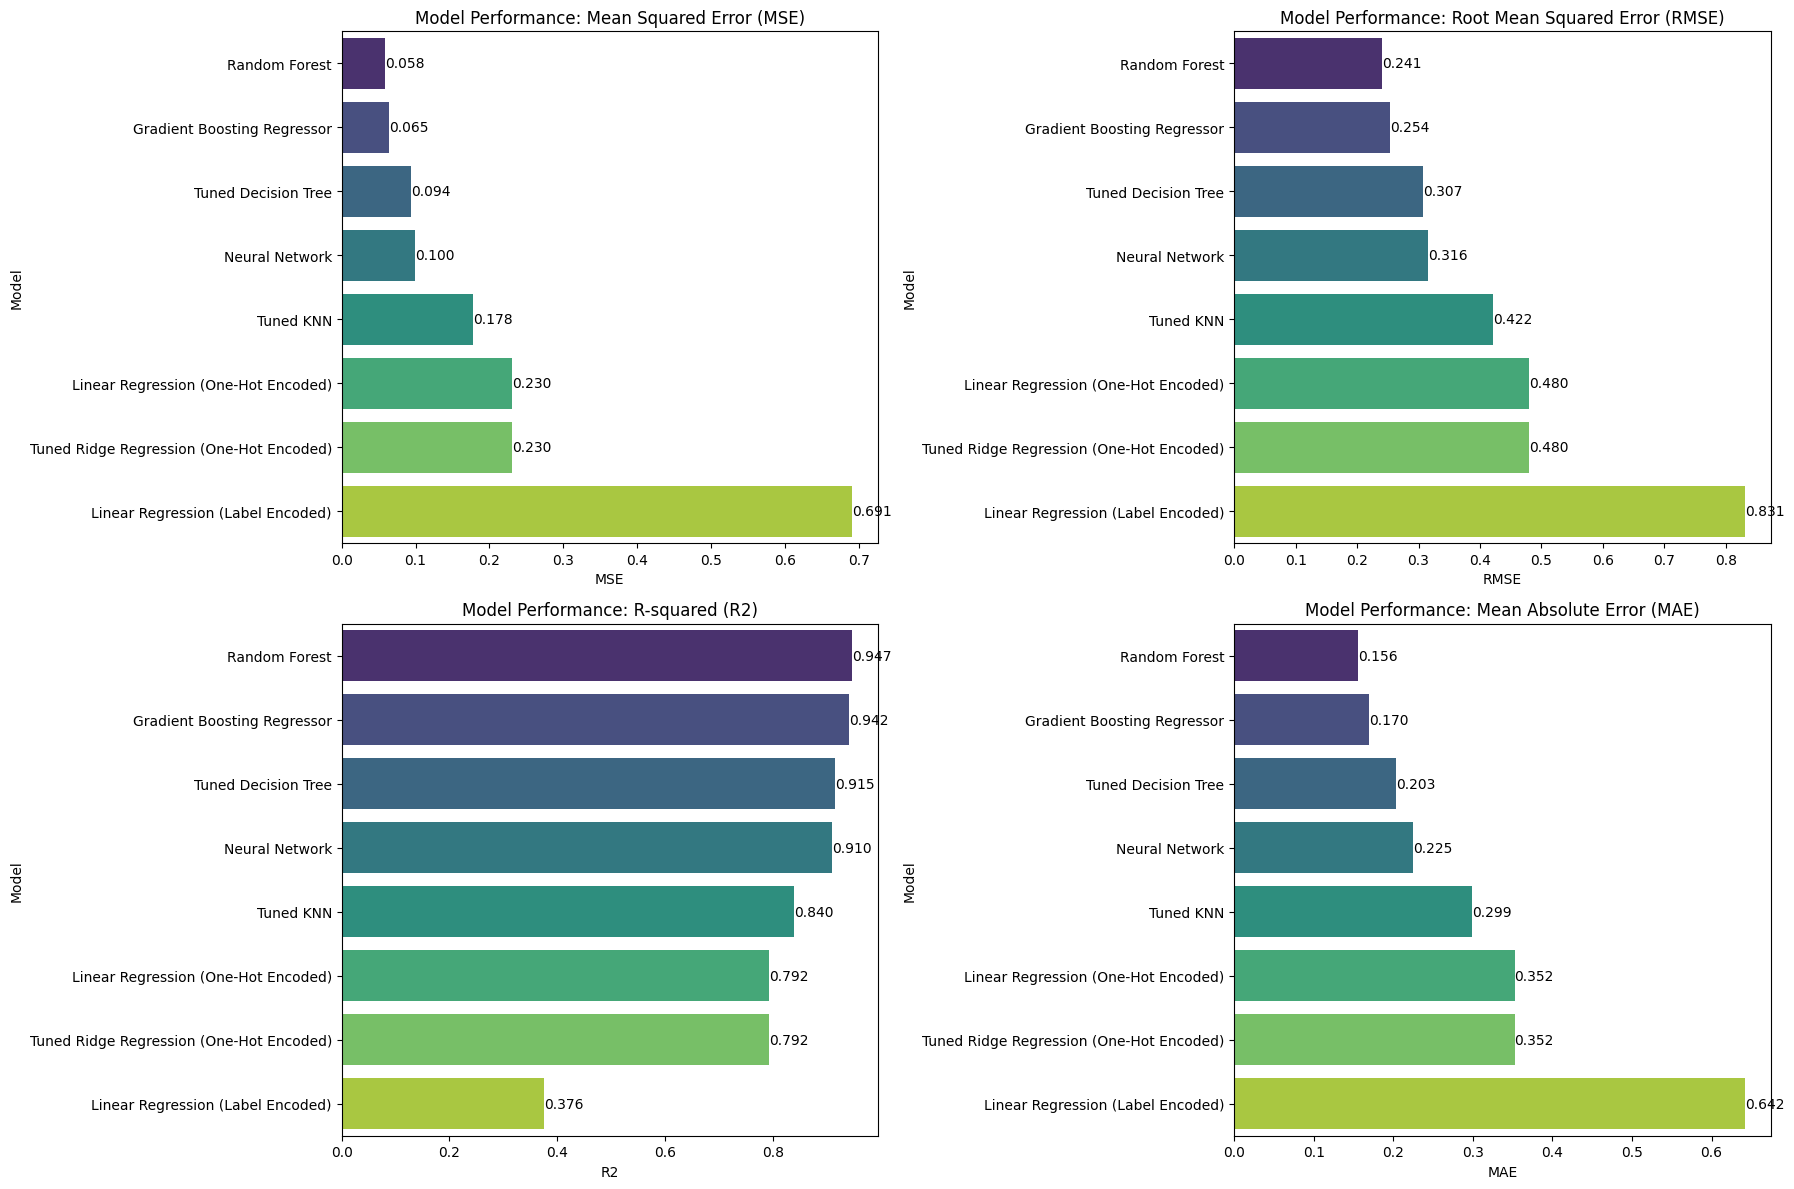

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


model_performance_updated = {
    'Random Forest': {
        'MSE': mse_rf,
        'RMSE': rmse_rf,
        'R2': r2_rf,
        'MAE': mae_rf
    },
    'Neural Network': {
        'MSE': mse_scaled_nn,
        'RMSE': rmse_scaled_nn,
        'R2': r2_scaled_nn,
        'MAE': mae_scaled_nn
    },
    'Tuned KNN': {
        'MSE': mse_tuned_knn_test,
        'RMSE': rmse_tuned_knn_test,
        'R2': r2_tuned_knn_test,
        'MAE': mae_tuned_knn_test
    },
    'Tuned Decision Tree': {
        'MSE': mse_tuned_dt,
        'RMSE': rmse_tuned_dt,
        'R2': r2_tuned_dt,
        'MAE': mae_tuned_dt
    },
    'Gradient Boosting Regressor': {
        'MSE': mse_gbr_test,
        'RMSE': rmse_gbr_test,
        'R2': r2_gbr_test,
        'MAE': mae_gbr_test
    },
    'Linear Regression (Label Encoded)': {
        'MSE': mse_lr_test,
        'RMSE': rmse_lr_test,
        'R2': r2_lr_test,
        'MAE': mae_lr_test
    },
    'Tuned Ridge Regression (One-Hot Encoded)': {
        'MSE': mse_tuned_ridge_ohe,
        'RMSE': rmse_tuned_ridge_ohe,
        'R2': r2_tuned_ridge_ohe,
        'MAE': mae_tuned_ridge_ohe
    },
    'Linear Regression (One-Hot Encoded)': {
        'MSE': mse_lr_ohe,
        'RMSE': rmse_lr_ohe,
        'R2': r2_lr_ohe,
        'MAE': mae_lr_ohe
    }
}

performance_df_updated = pd.DataFrame(model_performance_updated).T
performance_df_updated.index.name = 'Model'

performance_df_updated = performance_df_updated.sort_values(by='R2', ascending=False)


fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

metrics = ['MSE', 'RMSE', 'R2', 'MAE']
titles = [
    'Model Performance: Mean Squared Error (MSE)',
    'Model Performance: Root Mean Squared Error (RMSE)',
    'Model Performance: R-squared (R2)',
    'Model Performance: Mean Absolute Error (MAE)'
]

for i, metric in enumerate(metrics):

    sns.barplot(x=performance_df_updated[metric], y=performance_df_updated.index, ax=axes[i], palette='viridis', hue=performance_df_updated.index, legend=False)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel(metric)
    axes[i].set_ylabel('Model')


    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.3f')

plt.tight_layout()
plt.show()

In [159]:
import gradio as gr
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

RandomForestRegressor

admin1_choices = df['admin1'].unique().tolist()
admin2_choices = df['admin2'].unique().tolist()
market_choices = df['market'].unique().tolist()
commodity_choices = df['commodity'].unique().tolist()

def predict_price(admin1, admin2, market, month, year, commodity, latitude, longitude, day_of_week, day_of_year, week_of_year):
    input_data = pd.DataFrame({
        'admin1': [admin1],
        'admin2': [admin2],
        'market': [market],
        'month': [month],
        'year': [year],
        'commodity': [commodity],
        'latitude': [latitude],
        'longitude': [longitude],
        'day_of_week': [day_of_week],
        'day_of_year': [day_of_year],
        'week_of_year': [week_of_year]
    })


    categorical_features_for_dummies = [col for col in ['admin1', 'admin2', 'market', 'commodity'] if col in input_data.columns]
    input_data_processed = pd.get_dummies(input_data, columns=categorical_features_for_dummies, drop_first=True)


    missing_cols = set(X_train.columns) - set(input_data_processed.columns)
    for c in missing_cols:
        input_data_processed[c] = 0

    input_data_processed = input_data_processed[X_train.columns]


    scaled_prediction = model.predict(input_data_processed)


    original_price = scaler.inverse_transform(scaled_prediction.reshape(-1, 1))[0][0]

    return f"Predicted Price: {original_price:,.2f}"


interface = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Dropdown(admin1_choices, label="Admin1"),
        gr.Dropdown(admin2_choices, label="Admin2"),
        gr.Dropdown(market_choices, label="Market"),
        gr.Slider(minimum=1, maximum=12, step=1, label="Month"),
        gr.Slider(minimum=2000, maximum=2024, step=1, label="Year"),
        gr.Dropdown(commodity_choices, label="Commodity"),
        gr.Number(label="Latitude"),
        gr.Number(label="Longitude"),
        gr.Slider(minimum=0, maximum=6, step=1, label="Day of Week (0=Monday, 6=Sunday)"),
        gr.Slider(minimum=1, maximum=366, step=1, label="Day of Year"),
        gr.Slider(minimum=1, maximum=53, step=1, label="Week of Year")
    ],
    outputs="text",
    title="Uganda Food Price Prediction",
    description="Enter the features to predict the food price."
)

interface.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://7e8425d98fcf4649a9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://7e8425d98fcf4649a9.gradio.live
